In [1]:
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy.interpolate import griddata
from models import *
from IPython import display

### Model Parameters

Currently specified here in dictionaries. 

To-do: set up parameter file that will read into these dictionaries automatically 

In [2]:
stellar_params = {'Ms': 1, 'Rs': 1, 'Ts': 6000}
disk_params = {'Mdisk': 0.07, 'Mfrac': [0.01,0.05],'R0':[1,1], 'Rout':[150,150], 'H0':[0.05,0.025], 'p':[-1,-1], 'fi':[0.25,0.25], 'Rdisk':[30,30]}
envelope_params = {'Min': 5.0e-6, 'Rc':150, 'rho_amb':1e-30, 'rho_0': 1e-25,'theta_min': 20,'exf':0.25,'Rmax':5e5, 'd2g': 0.01 }
grid_params = {'N':[150,90,45], 'min':[0.1,pi/8.,0], 'max':[400,pi/2.,2*pi], 'spacing':['log','lin','lin']}
dust_params = {'rho_si':3.0, 'amin_chem':0.06, 'amax_ism': 1.0, 'amin': [0.005e-6,0.005e-6,0.005e-6], 
              'amax': [1e-6,1e-6,1e-3]}
RT_params = {'cr_model': 'ssx','zetacr': 1.3e-17,'LUV': 1, 'LX': 1e30}

In [3]:
d1 = model(stellar_params, disk_params, envelope_params,grid_params,dust_params,RT_params)
print('Assigned model directory:' + d1.outdir)

directory exists - will overwrite current model if you write to it!
Assigned model directory:/Users/aleksandra/Desktop/wedgeford/m1_test/


### Input Model Structure
Plot the model components

/Users/aleksandra/Desktop/wedgeford/models/make_model.py:155: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))
/Users/aleksandra/Desktop/wedgeford/models/make_model.py:120: RuntimeWarning: divide by zero encountered in log10
  contourf(R_CYL[:,:,0],Z_CYL[:,:,0], np.log10(rho[:,:,0]),**plot_params)
/Users/aleksandra/Desktop/wedgeford/models/make_model.py:155: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))
/Users/aleksandra/Desktop/wedgeford/models/make_model.py:120: RuntimeWarning: divide by zero encountered in log10
  contourf(R_CYL[:,:,0],Z_CYL[:,:,0], np.log10(rho[:,:,0]),**plot_params)
/Users/aleksandra/Desktop/wedgeford/models/make_model.py:155: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))
/Users/aleksandra/Desktop/wedgeford/models/make_model.py:120: RuntimeWarning: divide by ze

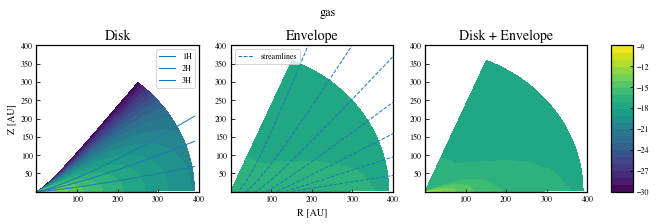

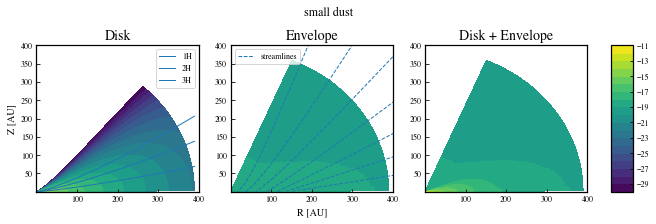

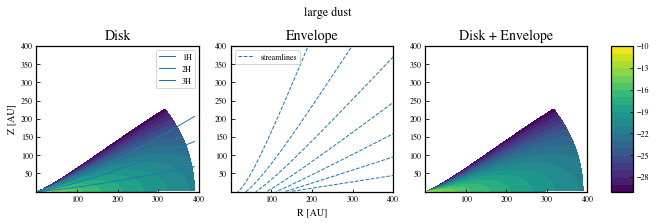

In [4]:
d1.plot_components(0)#gas
d1.plot_components(1)#small dust
d1.plot_components(2)#large dust

### Do the thermal radiative transfer for the dust

In [5]:
d1.write_grid()
d1.write_dust_density()


/Users/aleksandra/Desktop/wedgeford/models/make_model.py:144: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))


In [6]:

d1.RT_Tdust()


0

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


/Users/aleksandra/Desktop/wedgeford/models/make_model.py:313: RuntimeWarning: divide by zero encountered in log10
  ax[1].contour(X, Z, np.log10(data.rhodust[:,:,0,1].T),levels=np.arange(-19,-11,1),colors='white')


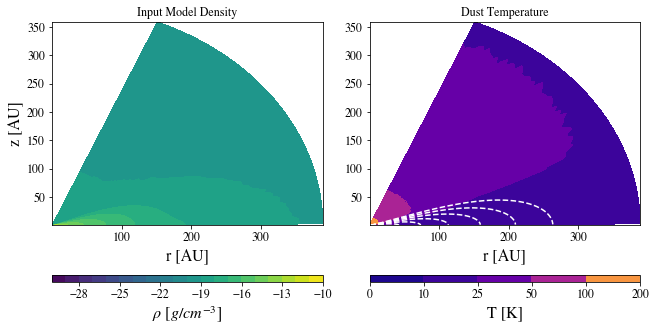

In [7]:
d1.plot_RT()

### Make some images (if you want)

In [39]:
rpy.image.makeImage(npix=400., wav=2100, incl=90, phi=15., sizeau=600.)



Executing RADMC-3D Command:
radmc3d image npix 400 incl 90 sizeau 600.0 lambda 2100 phi 15.0 pointau 0.0  0.0  0.0 fluxcons


0

Reading image.out


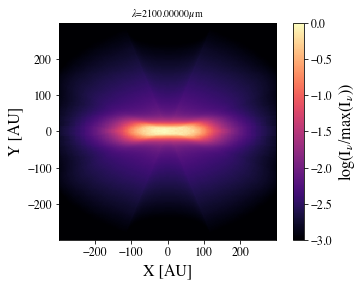

{'implot': <matplotlib.image.AxesImage at 0x7ff70f6b6fd0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7ff71e5cc550>}

In [40]:
im = rpy.image.readImage(binary=False)
rpy.image.plotImage(im, au=True, log=True, maxlog=3, saturate=1, cmap=cm.magma)

### Make your new grid for the chemistry

In [ ]:
write_out(d1)

<ipython-input-5-099c7d7d5a47>:15: RuntimeWarning: divide by zero encountered in log10
  method(data['r'],data['z'],np.log10(data[prop]),**pk)


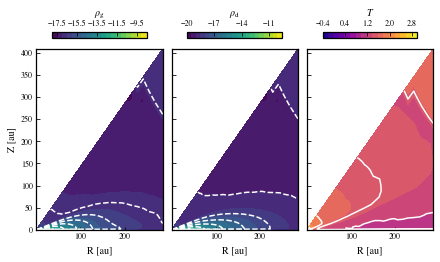

In [29]:
f, ax = subplots(1,3,constrained_layout=True)
f.set_size_inches((6,3.5))
grid = False
os.chdir(d1.outdir)
for col,prop,cmap,label in zip(ax,['rhog','rhod','Td'],['viridis','viridis','plasma'],[r'$\rho_{\rm g}$',r'$\rho_{\rm d}$',r'$T$']):
    sca(col)
    plot_out(prop=prop,cmap=cmap,levels=20)
    cbar = colorbar(ax=col,location='top',shrink=0.75,aspect=8,label=label)
    cbar.set_ticks(cbar.get_ticks()[::2])
    plot_out(prop=prop,method=contour,colors='white',levels=10)
    axis('scaled')
    xlabel('R [au]')
    if col == ax[0]:
        ylabel('Z [au]')
    else:
        col.yaxis.set_major_formatter(NullFormatter())
    d2 = read_out()
    if grid == True:
        plot(d2['r'].flatten(),d2['z'].flatten(),'w,',alpha=0.5) #grid points
    

In [30]:
Msun = 1.9891e33 # g
Rsun = 69.6e9 #cm
Lsun  = 3.8525e33 #erg/s
AU = 1.49598e13 #cm
yr = 3.14e7 #seconds
cmtokm = 10**(-5) #converts cm to km
R_mu = 36149835 # (R/mu) for 2.4 g/mol in PPD
Gconv = 6.6743e-8 # cgs
S0conv = (Msun/(AU**2)) #S0cgs = S0code*S0conv
sigsb = 5.67e-5 #Stefan Boltzmann constant
c = 2.99792458e10 # speed of light
mu = 2.36
h = 6.6260755e-27 #planck
mh = 1.67e-24 # mass of hydrogen cgs
Habing = 1.83590e+08  # Photons/cm^2/s between 930-2000
G0 = 2.7e-3 # erg/cm^2/s^-1


def write_out(model,outname='model',ndust=2): #write the .out file for RT and chemistry, pass the model class into this
    m = model
    if os.getcwd() != m.outdir:
        os.chdir(m.outdir)
    r,z = m.make_rz_H()
    T = m.get_Tdust()
    rho_g = m.rho_embedded(fluid=0)
    rho_d = np.zeros_like(T)
    for fluid in np.arange(ndust):
        rho_d += m.get_rhodust(fluid=fluid+1)
    rhod_2d = m.make_quadrant(rho_d, fill_value = np.median(rho_d)/2.,order='F').T.flatten()
    T_2d = m.make_quadrant(T,fill_value = np.median(T)/2.,order='F').T.flatten()
    rhog_2d = m.make_quadrant(rho_g, fill_value = np.median(rho_g)/2., order='C').T.flatten()
    
    header1 = 'R(AU)    z(AU)   rhogas(g/cm3)  rhodust(g/cm^3)    T(K)   [    4 types of dust]      f_H\n'
    header2 = '-ForChem+Plots--------------------------------------------------------\n'
    outfile = open(outname+'.out',"w")
    outfile.write(header1)
    outfile.write(header2)
    for n in np.arange(len(r.flatten())):
        outfile.write('%10.4f %10.4f   %5.2e   %5.2e %7.1f %12.7f %12.7f %12.7f %12.7f   %7.2e\n'%(r.T.flatten()[n],z.T.flatten()[n],rhog_2d[n], rhod_2d[n] ,T_2d[n],1.0,0.0,0.0,0.0,1.0))
    outfile.close()
    return outname + '.out'

def read_out(outname='model.out'): #convenience function for reading the .out file and returning the bits accessible as dictionary
    data = np.loadtxt(outname,skiprows=2,usecols=(0,1,2,3,4))
    r = data[:,0]
    z = data[:,1]
    shape = (len(np.unique(r)),50)
    rhog = data[:,2].reshape(shape)
    rhod = data[:,3].reshape(shape)
    T = data[:,4].reshape(shape)
    out_dict = {'r':r.reshape(shape), 'z':z.reshape(shape),'rhog':rhog,'rhod':rhod,'Td':T}
    return out_dict

def plot_out(prop='rhog',outname='model.out',log=True,method=contourf,**pk): #plotting convenience function to inspect .out file contents
    data = read_out(outname)
    if log == True:
        method(data['r'],data['z'],np.log10(data[prop]),**pk)
    else:
        method(data['r'],data['z'],(data[prop]),**pk) 

In [61]:
uvfiletest = '../highenergy_RT/uv_photons_0.03Mslg_0.5m_0.1dg_uv_e1.dat'
def Tgas_from_UV(outname='model.out',uvfile='uv_photons.dat'):
    data = read_out(outname)
    n_points = len(data['r'].flatten())
    n_r = np.shape(data['rhod'])[0]
    n_z = np.shape(data['rhod'])[1]
    
    lvec = np.linspace(1,108,108)*10+920
    evec = h*c/(lvec*1e-8)
    
    all_flux = np.zeros((n_r,n_z))
    n_rchunk = 111 
    
    def integrate_spectrum(photons):
        evec2d = np.tile(evec,(np.shape(photons)[-1],1)).T
        integral = np.trapz(photons*evec2d,x=lvec,axis=0)/G0
        return integral
    
    for j in range(n_r):
        spectra = np.genfromtxt(uvfile,skip_header=4+j*n_rchunk,max_rows=108)
        photons = spectra[:,1:]
        integral = integrate_spectrum(photons)
        all_flux[j,:] += integrate_spectrum(photons)
        
    NH2 = data['rhog']/(mu*mh) #gas density in n mol.
    NH = 2.0*NH2 # gas density in n atom
    x = np.log10(NH/1e5)
    x[x>9.2920]=9.29199  # Max density where this works is ~1e14 cm^-3. #threshold density cap for H2 dissociation

    all_flux = np.clip(all_flux, a_min=0, a_max=None)
    delT = 420.2*(all_flux/1e3)**(1.05-0.113*x)*1.0/(10**(0.486*x-0.014*x**2)) # change in temperature based on integral
    delT[NH<1e-2] = 0.0 #set to 0 for threshhold density
    
    data['Tg'] = np.clip(data['Td']+delT,a_min=None,a_max= 4200.) #modify calculated T diff from dust T
    return data
        
#Tgas_from_UV(uvfile=uvfiletest)


{'r': array([[1.000000e-01, 1.000000e-01, 1.000000e-01, ..., 1.000000e-01,
         1.000000e-01, 1.000000e-01],
        [1.057000e-01, 1.057000e-01, 1.057000e-01, ..., 1.057000e-01,
         1.057000e-01, 1.057000e-01],
        [1.118000e-01, 1.118000e-01, 1.118000e-01, ..., 1.118000e-01,
         1.118000e-01, 1.118000e-01],
        ...,
        [2.562482e+02, 2.562482e+02, 2.562482e+02, ..., 2.562482e+02,
         2.562482e+02, 2.562482e+02],
        [2.709166e+02, 2.709166e+02, 2.709166e+02, ..., 2.709166e+02,
         2.709166e+02, 2.709166e+02],
        [2.864248e+02, 2.864248e+02, 2.864248e+02, ..., 2.864248e+02,
         2.864248e+02, 2.864248e+02]]),
 'z': array([[0.000000e+00, 1.000000e-04, 2.000000e-04, ..., 1.071000e-01,
         1.237000e-01, 1.428000e-01],
        [0.000000e+00, 2.000000e-04, 2.000000e-04, ..., 1.132000e-01,
         1.308000e-01, 1.510000e-01],
        [0.000000e+00, 2.000000e-04, 2.000000e-04, ..., 1.197000e-01,
         1.382000e-01, 1.596000e-01],
   

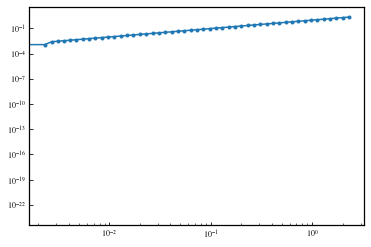

In [137]:
def cosmic_ray_zeta(outname = 'model.out',cr_model='m02'):
    data = read_out(outname)
    
    def zetaeval(ncol,model=cr_model):
        labels = ['m02','w98','ssm','ssx','ttm','ttx']
        #Rates from Cleeves et al. 2014
        #zeta_powerlaw alpha zeta_exponential Sigma
        allrts = np.array([[6.8e-16,3.7e-18,0.423,210.0],
            [2.0e-17,9.4e-19,0.021,260.0],
            [1.1e-18,3.0e-19,-0.00,260.0],
            [1.6e-19,7.5e-20,-0.01,250.0],
            [7.0e-21,4e-21,-0.01,290.0],
            [1.1e-22,3e-23,-0.02,490.0]])

        modin = labels.index(model)
        zp = allrts[modin,0]
        ze = allrts[modin,1]
        al = allrts[modin,2]
        co = allrts[modin,3]
        mumult = 2.36
        piv = 1e20
        F = zp*ze*mumult/(ze*mumult*(ncol/piv)**al+zp*(exp(ncol*2.0*mh/co)-1)) #C13 eq5
        return F
    
    Ncol_external = 1e10 #column before disk surface
    
    rhog = data['rhog']
    axis = 1
    rpts = np.unique(data['r'])
    zcm = np.reshape((1e-10/AU)*np.ones_like(rpts),(len(rpts),1)) #start of midplane
    z_faces = np.append(zcm, (data['z'][:,1:]+data['z'][:,:-1])/2.,axis=1) #find the faces based on the centers
    
    rhog_los = np.append(np.flip(rhog,axis=axis),rhog,axis=axis)
    dz_los = np.append(np.flip(dz,axis=axis),dz,axis=axis)
    Ncol_zpos = np.cumsum(rhog_los*dz_los,axis=axis)/(mu*mh) + Ncol_external
    Ncol_zneg = np.cumsum(np.flip(rhog_los*dz_los,axis=axis),axis=axis)/(mu*mh) + Ncol_external
    zeta = 0.5*zetaeval(Ncol_zpos,model=cr_model) + 0.5*zetaeval(Ncol_zneg,model=cr_model)
    data['zeta'] = zeta[:,:50]
    return data

cosmic_ray_zeta()

In [ ]:
#################################################################################
def Create_0io(dir,runnm,uv,xr,isrf,slr,st,rre,rsp,ioname):

    finp = dir+'/environ/'+runnm+'/'+ioname
    fi = open(finp,'w')
    fi.write('# input & output files:\n')
    fi.write('{:<45}'.format(rsp)+'# file with species\n')
    fi.write('{:<45}'.format(rre)+'# file with reactions\n')
    fi.write('{:<45}'.format(uv)+'# file with uvfield\n')
    fi.write('{:<45}'.format(xr)+'# file with xrfield\n')
    fi.write('{:<45}'.format(isrf)+'# file with ISRF\n')
    fi.write('{:<45}'.format(slr)+'# Radionuclide Ion Rate\n')
    fi.write('{:<45}'.format(st)+'# 2D abundance file ending\n')
    fi.close()

    for file in os.listdir(dir+'/environ/'):
        if fnmatch.fnmatch(file,runnm+'*'):
            foundfile = file
            if file != runnm:
                shutil.copy2(finp,dir+'/environ/'+foundfile+'/'+ioname)

    return


In [10]:
if not os.path.exists(outdir):
		os.makedirs(outdir)
zetacr = 1.3e-17
	for n in range(len(r)): #write a new file for each radius?
		#outfile = open(outdir+'1environ.inp.e1.'+np.round(r[n],decimals=4))
		#outfile.write('  R             rho           Tgas          Tdust        zAU           zcm           Nrz           ZetaCR        DustFrac\n')
		#outfile.write('1\n')
		#outfile.write(str(nz)+'\n')
		if n !=0 and r[n] == r[n-1]:
			nsig_unset = -3.0 *rhog[n] * dust2gas/rho_si * (amax_ism**-0.5 - amin_chem**-0.5)/ \
			(amax_ism**-0.5 - amin_chem**-0.5)
			nsig_tot = 0.0
			for d in range(ndust):
				nsig = -3.0 *rhod[d,n]/rho_si * (amax[d]**-0.5 - amin[d]**-0.5)/ \
				(amax[d]**-0.5 - amin[d]**-0.5)
				nsig_tot = nsig_tot + nsig
			dustfrac = nsig_tot/nsig_unset
			zcm = zcm + np.abs(z[n]-z[n-1])
		else:
			zcm = 1e-10
			print("new radius:",r[n],z[n])
            
    #outfile.write(' %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E\n'%(r[n],rhod[n],Td[n],Td[n],z[n],zcm,1e10,zetacr,dustfrac))

In [ ]:
isrf_model = 'isrf_'+isrf_vals[i]+'_half_'+env_orig[e]+'.dat'
isrf_model = 'None'
ioname = '0io.'+str(int(float(isrf_vals[i])))+'G0.x'+str(int(float(xr_vals[x])))+'.inp'
#print(diskchem_dir,env_orig[e],uv_model[e],short_env_orig[e])
Tgas_Comp(diskchem_dir,env_orig[e],uv_model[e],short_env_orig[e])
Generate_Environment(diskchem_dir,env_orig[e])
Create_0io(diskchem_dir,env_orig[e],uv_model[e],xr_model,isrf_model,slr_model[e],srt_time[e],rreac,rspec,ioname)